<a href="https://colab.research.google.com/github/p-disha/COVID19-Chest-x-ray/blob/master/COVID19%20Chest%20X-Ray%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are three main goals for this project
(1) to explore development of a machine learning algorithm to distinguish chest X-rays of individuals with respiratory illness testing positive for COVID-19 from other X-rays,
(2) to promote discovery of patterns in such X-rays via machine learning interpretability algorithms(LIME, SHAP), and
(3) to build more robust and extensible machine learning infrastructure trained on a variety of data types, to aid in the global response to COVID-19.

Installing required libraries

In [ ]:
!pip install pydicom
!pip install -U PyYAML

     |████████████████████████████████| 35.3MB 99kB/s 
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=a17315256b66012878491b0a5193120e6a3397d553458566cc2cf6776cc37656
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import yaml
yaml.__version__

'5.3.1'

Checking the versions of the libraries to check for compatibility

In [ ]:
!pip install -U tensorflow-gpu==2.0.1
%tensorflow_version 2.0.1
#import PyYAML
import matplotlib
import tqdm
#import opencv
import tensorflow
import dill
import sklearn
import numpy as np
import pandas
import pydicom
import tensorboard
#yaml.__version__
print(matplotlib.__version__)
print(tqdm.__version__)
print(tensorflow.__version__)
print(dill.__version__)
print(sklearn.__version__)
print(np.__version__)
print(pandas.__version__)
print(pydicom.__version__)
print(tensorboard.__version__)


     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 29.4MB/s 
     |████████████████████████████████| 3.8MB 10.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=6de00fde70cce0a7d2ee8f087a6a916bbd7a142b4d974223b39a938a31f03131
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstall

In [ ]:
'''
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
'''

In [ ]:
'''
link = 'https://drive.google.com/open?id=1AGpUZTsW4_XkXfaG9wlYU8_Sz2eEyF7N'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Filename.csv')
df3 = pd.read_csv('Filename.csv')
'''

Mounting Google drive to read the dataset to train the model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


DATA PREPROCESSING

The dataset is already preprocessed locally so we just load the dataset from local

In [ ]:
#!pip install pydicom
import numpy as np
import pandas as pd
import pydicom as dicom
import yaml
import os
import pathlib
import shutil
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split


Here we combine datasets from three differenrt sources two github repositories and one from kaggle and pre process them to store the images names in a csv file which will help us to load the images in th eupcoming steps

Most of the path's, folder name's and parameters are stored in the config.yml file which we load from local computer. In this experiment we are performing binary classification where the two classes to be classified are COVID and NON-COVID.

In [ ]:
def build_dataset(cfg):
    '''
    Build a dataset of filenames and labels according to the type of classification
    :param cfg: Project config dictionary
    :return: DataFrame of file names of examples and corresponding class labels
    '''

    # Get paths of raw datasets to be included
    mila_data_path = cfg['PATHS']['MILA_DATA']
    fig1_data_path = cfg['PATHS']['FIGURE1_DATA']
    rsna_data_path = cfg['PATHS']['RSNA_DATA']

    # Assemble filenames comprising Mila dataset
    mila_df = pd.read_csv(mila_data_path + 'metadata.csv')
    mila_df['filename'] = mila_data_path + 'images/' + mila_df['filename'].astype(str)
    mila_views_cxrs_df = (mila_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
    mila_covid_pts_df = (mila_df['finding'] == 'COVID-19')
    mila_covid_views_df = mila_df[mila_covid_pts_df & mila_views_cxrs_df]  # Images for patients diagnosed with COVID-19

    # Assemble filenames comprising Figure 1 dataset
    fig1_df = pd.read_csv(fig1_data_path + 'metadata.csv', encoding='ISO-8859-1')
    fig1_df['filename'] = ''
    for i, row in fig1_df.iterrows():
        if os.path.exists(fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.jpg'):
            fig1_df.loc[i, 'filename'] = fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.jpg'
        else:
            fig1_df.loc[i, 'filename'] = fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.png'
    fig1_df['view'].fillna('PA or AP', inplace=True)    # All images in this dataset are either AP or PA
    fig1_views_cxrs_df = (fig1_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
    fig1_covid_pts_df = (fig1_df['finding'] == 'COVID-19')
    fig1_covid_views_df = fig1_df[fig1_covid_pts_df & fig1_views_cxrs_df]  # Images for patients diagnosed COVID-19

    # Assemble filenames comprising RSNA dataset
    rsna_metadata_path = rsna_data_path + 'stage_2_train_labels.csv'
    rsna_df = pd.read_csv(rsna_metadata_path)
    num_rsna_imgs = cfg['DATA']['NUM_RSNA_IMGS']
    rsna_normal_df = rsna_df[rsna_df['Target'] == 0]
    rsna_pneum_df = rsna_df[rsna_df['Target'] == 1]

    # Convert dicom files of CXRs with no findings to jpg if not done already in a previous run. Select desired views.
    file_counter = 0
    normal_idxs = []
    for df_idx in rsna_normal_df.index.values.tolist():
        filename = rsna_normal_df.loc[df_idx]['patientId']
        ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
        if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
            if not os.path.exists(rsna_data_path + filename + '.jpg'):
                cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)   # Save as .jpg
            normal_idxs.append(df_idx)
            file_counter += 1
        if file_counter >= num_rsna_imgs // 2:
            break
    rsna_normal_df = rsna_normal_df.loc[normal_idxs]

    # Convert dicom files of CXRs with pneumonia to jpg if not done already in a previous run. Select desired views.
    file_counter = 0
    pneum_idxs = []
    num_remaining = num_rsna_imgs - num_rsna_imgs // 2
    for df_idx in rsna_pneum_df.index.values.tolist():
        filename = rsna_pneum_df.loc[df_idx]['patientId']
        ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
        if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
            if not os.path.exists(rsna_data_path + filename + '.jpg'):
                cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)  # Save as .jpg
            pneum_idxs.append(df_idx)
            file_counter += 1
        if file_counter >= num_remaining:
            break
    rsna_pneum_df = rsna_pneum_df.loc[pneum_idxs]

    mode = cfg['TRAIN']['CLASS_MODE']
    n_classes = len(cfg['DATA']['CLASSES'])
    class_dict = {cfg['DATA']['CLASSES'][i]: i for i in range(n_classes)}  # Map class name to number
    label_dict = {i: cfg['DATA']['CLASSES'][i] for i in range(n_classes)}  # Map class name to number

    if mode == 'binary':
        mila_covid_views_df['label'] = 1                                       # Mila images with COVID-19 diagnosis
        mila_other_views_df = mila_df[~mila_covid_pts_df & mila_views_cxrs_df]
        mila_other_views_df['label'] = 0                                       # Mila images with alternative diagnoses
        fig1_covid_views_df['label'] = 1                                       # Figure 1 images with COVID-19 diagnosis
        file_df = pd.concat([mila_covid_views_df[['filename', 'label']], mila_other_views_df[['filename', 'label']],
                             fig1_covid_views_df[['filename', 'label']]], axis=0)

        rsna_df = pd.concat([rsna_normal_df, rsna_pneum_df], axis=0)
        rsna_filenames = rsna_data_path + rsna_df['patientId'].astype(str) + '.jpg'
        rsna_file_df = pd.DataFrame({'filename': rsna_filenames, 'label': 0})

        file_df = pd.concat([file_df, rsna_file_df], axis=0)         # Combine both datasets
    else:
        mila_covid_views_df['label'] = class_dict['COVID-19']
        mila_views_pneum_df = mila_df[mila_df['finding'].isin(['SARS', 'Steptococcus', 'MERS', 'Legionella', 'Klebsiella',
                                                            'Chlamydophila', 'Pneumocystis']) & mila_views_cxrs_df]
        mila_views_pneum_df['label'] = class_dict['other_pneumonia']                 # Mila CXRs with other peumonias
        mila_views_normal_df = mila_df[mila_df['finding'].isin(['No finding']) & mila_views_cxrs_df]
        mila_views_normal_df['label'] = class_dict['normal']                         # Mila CXRs with no finding
        fig1_covid_views_df['label'] = class_dict['COVID-19']                        # Figure 1 CXRs with COVID-19 finding
        file_df = pd.concat([mila_covid_views_df[['filename', 'label']], mila_views_pneum_df[['filename', 'label']],
                             mila_views_normal_df[['filename', 'label']], fig1_covid_views_df[['filename', 'label']]], axis=0)

        # Organize some files from RSNA dataset into "normal", and "pneumonia" XRs
        rsna_normal_filenames = rsna_data_path + rsna_normal_df['patientId'].astype(str) + '.jpg'
        rsna_pneum_filenames = rsna_data_path + rsna_pneum_df['patientId'].astype(str) + '.jpg'
        rsna_normal_file_df = pd.DataFrame({'filename': rsna_normal_filenames, 'label': class_dict['normal']})
        rsna_pneum_file_df = pd.DataFrame({'filename': rsna_pneum_filenames, 'label': class_dict['other_pneumonia']})
        rsna_file_df = pd.concat([rsna_normal_file_df, rsna_pneum_file_df], axis=0)

        file_df = pd.concat([file_df, rsna_file_df], axis=0)  # Combine both datasets

    file_df['label_str'] = file_df['label'].map(label_dict) # Add column for string representation of label
    return file_df

We observed from the lime explanation that most of the images have characters printed on them and the training algorithm was using that feature also for the purpose of prediction which is wrong. So in the remove_text method we try tp remove all the text's present on the image. This leads the models to not use these text encoding on the images as a feature for prediction.

In [ ]:
def remove_text(img):
    '''
    Attempts to remove bright textual artifacts from X-ray images. For example, many images indicate the right side of
    the body with a white 'R'. Works only for very bright text.
    :param img: Numpy array of image
    :return: Array of image with (ideally) any characters removed and inpainted
    '''
    #print("inside remove_text")
    mask = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)[1][:, :, 0].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS).astype(np.float32)
    return result


We split the dataset into three parts for Train, Validation and Test.

In [ ]:
def preprocess(cfg=None):
    '''
    Preprocess and partition image data. Assemble all image file paths and partition into training, validation and
    test sets. Copy raw images to folders for training, validation and test sets.
    :param mode: Type of classification. Set to either 'binary' or 'multiclass'
    '''

    if cfg is None:
        cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))  # Load config data

    # Build dataset based on type of classification
    file_df = build_dataset(cfg)

    # Split dataset into train, val and test sets
    val_split = cfg['DATA']['VAL_SPLIT']
    test_split = cfg['DATA']['TEST_SPLIT']
    file_df_train, file_df_test = train_test_split(file_df, test_size=test_split, stratify=file_df['label'])
    relative_val_split = val_split / (1 - test_split)  # Calculate fraction of train_df to be used for validation
    file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_val_split,
                                                      stratify=file_df_train['label'])

    # Save training, validation and test sets
    file_df_train.to_csv(cfg['PATHS']['TRAIN_SET'])
    file_df_val.to_csv(cfg['PATHS']['VAL_SET'])
    file_df_test.to_csv(cfg['PATHS']['TEST_SET'])
    return

In [ ]:
#if __name__ == '__main__':
#    preprocess()

MODEL

In [ ]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D, Conv2D, Flatten, LeakyReLU, BatchNormalization, \
    Activation, concatenate, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import Constant
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2
from tensorflow.keras.utils import multi_gpu_model

Visualization

The methods defined below are responsible visualizing the model


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import io
import os
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries

In [ ]:
tf.__version__

'2.0.1'

In [ ]:
# Set some matplotlib parameters
mpl.rcParams['figure.figsize'] = (12, 10)

It is extremely important to understand the Receiver Operating Curve that gives raise to many classification quality metrics

In [ ]:
def plot_to_tensor():
    '''
    Converts a matplotlib figure to an image tensor
    :param figure: A matplotlib figure
    :return: Tensorflow tensor representing the matplotlib image
    '''
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    image_tensor = tf.image.decode_png(buf.getvalue(), channels=4)     # Convert .png buffer to tensorflow image
    image_tensor = tf.expand_dims(image_tensor, 0)     # Add the batch dimension
    return image_tensor

def plot_metrics(history, metrics, dir_path=None):
    '''
    Plot metrics for the training and validation sets over the training history.
    :param history: Model history; returned from model.fit()
    :param metrics: List of metrics to plot
    :param dir_path: Directory in which to save image
    '''
    plt.clf()
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(history.epoch,  history.history[metric], label='Train')    # Plot metric on training data
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')    # Plot metric on validation data
        plt.xlabel('Epoch')
        plt.ylabel(name)

        # Set plot limits depending on the metric
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])
        plt.legend()
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        plt.savefig(dir_path + 'metrics_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png')
    return

def plot_roc(name, labels, predictions, class_id=1, dir_path=None):
    '''
    Plots the ROC curve for predictions on a dataset
    :param name: Name of dataset on the plot
    :param labels: Ground truth labels
    :param predictions: Model predictions corresponding to the labels
    :param class_id: Index of class to consider
    :param dir_path: Directory in which to save image
    '''
    print("indside plot _roc")
    plt.clf()
    single_class_preds = predictions[:, class_id]    # Only care about one class
    single_class_labels = (np.array(labels) == class_id) * 1.0
    predictions = single_class_preds
    labels = single_class_labels
    fp, tp, _ = roc_curve(labels, predictions)  # Get values for true positive and true negative
    plt.plot(100*fp, 100*tp, label=name, linewidth=2)   # Plot the ROC curve
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-5,105])
    plt.ylim([-5,105])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        plt.savefig(dir_path + 'ROC_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png')
    print("after plotting roc")
    return plt

def plot_confusion_matrix(labels, predictions, class_id=1, dir_path=None):
    '''
    Plot a confusion matrix for the ground truth labels and corresponding model predictions for a particular class.
    :param labels: Ground truth labels
    :param predictions: Model predictions
    :param class_id: Index of class to consider
    :param dir_path: Directory in which to save image
    '''
    plt.clf()
    p = 1.0 / np.unique(labels).shape[0]
    single_class_preds = predictions[:, class_id]    # Only care about one class
    single_class_labels = (np.array(labels) == class_id) * 1.0
    predictions = single_class_preds
    labels = single_class_labels
    ax = plt.subplot()
    cm = confusion_matrix(labels, predictions > p)  # Calculate confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Plot confusion matrix
    ax.figure.colorbar(im, ax=ax)
    ax.set(yticks=[-0.5, 1.5], xticks=[0, 1], yticklabels=['0', '1'], xticklabels=['0', '1'])
    ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(base=1, offset=0.5))

    # Print number of TPs, FPs, TNs, FNs on each quadrant in the plot
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Set plot's title and axis names
    plt.title('Confusion matrix p={:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # Save the image
    if dir_path is not None:
        plt.savefig(dir_path + 'CM_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png')

    # Print these statistics
    print('True (-)ves: ', cm[0][0], '\nFalse (+)ves: ', cm[0][1], '\nFalse (-)ves: ', cm[1][0], '\nTrue (+)ves: ',
          cm[1][1])
    return plt


def visualize_explanation(orig_img, explanation, img_filename, label, probs, class_names, label_to_see='top', dir_path=None):
    '''
    Visualize an explanation for the prediction of a single X-ray image.
    :param orig_img: Original X-Ray image
    :param explanation: ImageExplanation object
    :param img_filename: Filename of the image explained
    :param label: Ground truth class of the example
    :param probs: Prediction probabilities
    :param class_names: Ordered list of class names
    :param label_to_see: Label to visualize in explanation
    :param dir_path: Path to directory where to save the generated image
    :return: Path to saved image
    '''

    # Plot original image on the left
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)

    # Plot the image and its explanation on the right
    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10,
                                                hide_rest=False)
    ax[1].imshow(mark_boundaries(temp, mask))

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.02, 0.8, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.82, "Predicted Class: " + str(pred_class) + ' (' + class_names[pred_class] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.84, "Ground Truth Class: " + str(label) + ' (' + class_names[label] + ')', fontsize=10)
    fig.suptitle("LIME Explanation for image " + img_filename, fontsize=15)
    fig.tight_layout()

    # Save the image
    filename = None
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        filename = dir_path + img_filename + '_exp_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png'
        plt.savefig(filename)
    return filename

def visualize_heatmap(orig_img, heatmap, img_filename, label, probs, class_names, file_path=None):
    '''
    Obtain a comparison of an original image and heatmap produced by Grad-CAM.
    :param orig_img: Original X-Ray image
    :param heatmap: Heatmap generated by Grad-CAM.
    :param img_filename: Filename of the image explained
    :param label: Ground truth class of the example
    :param probs: Prediction probabilities
    :param class_names: Ordered list of class names
    :param file_path: Path to save the generated image
    :return: Path to saved image
    '''

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)
    ax[1].imshow(heatmap)

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.02, 0.8, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.82, "Predicted Class: " + str(pred_class) + ' (' + class_names[pred_class] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.84, "Ground Truth Class: " + str(label) + ' (' + class_names[label] + ')', fontsize=10)
    fig.suptitle("Grad-CAM heatmap for image " + img_filename, fontsize=15)
    fig.tight_layout()

    # Save the image
    filename = None
    if file_path is not None:
        filename = file_path + img_filename + '_gradcam_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png'
        plt.savefig(filename)
    return filename

METRICS.PY

Below methods are responsible for calculating the F-1 score for the trained model. If the outcome from a prediction is p and the actual value is also p, then it is called a true positive (TP); however if the actual value is n then it is said to be a false positive (FP). Conversely, a true negative (TN) has occurred when both the prediction outcome and the actual value are n, and false negative (FN) is when the prediction outcome is n while the actual value is p.

In the case of this problem. When a person tests positive for COVID-19 but actually doesn't have the disease it is know as False Positive. When the person is tested positive and if they also have the disease the it is True Positive. If the person doesn't is not tested positive but actually has the disease then is is know as False Negative. If a person is tested negative and also doesn't have the disease then it is know as True Negative. The count for each of the four classes according to our models prediction is drawn below.

In [ ]:
import numpy as np
from tensorflow.keras.metrics import Metric, Precision, Recall
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
from tensorflow.python.keras import backend as K

In [ ]:
class F1Score(Metric):
    '''
    Custom tf.keras metric that calculates the F1 Score
    '''

    def __init__(self, thresholds=None, top_k=None, class_id=None, name=None, dtype=None):
        '''
        Creates an instance of the  F1Score class
        :param thresholds: A float value or a python list/tuple of float threshold values in [0, 1].
        :param top_k: An int value specifying the top-k predictions to consider when calculating precision
        :param class_id: Integer class ID for which we want binary metrics. This must be in the half-open interval
                `[0, num_classes)`, where `num_classes` is the last dimension of predictions
        :param name: string name of the metric instance
        :param dtype: data type of the metric result
        '''
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.init_thresholds = thresholds
        self.top_k = top_k
        self.class_id = class_id

        default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
        self.thresholds = metrics_utils.parse_init_thresholds(
            thresholds, default_threshold=default_threshold)
        self.true_positives = self.add_weight('true_positives', shape=(len(self.thresholds),),
                                              initializer=init_ops.zeros_initializer)
        self.false_positives = self.add_weight('false_positives', shape=(len(self.thresholds),),
                                               initializer=init_ops.zeros_initializer)
        self.false_negatives = self.add_weight('false_negatives', shape=(len(self.thresholds),),
                                               initializer=init_ops.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates true positive, false positive and false negative statistics.
        :param y_true: The ground truth values, with the same dimensions as `y_pred`. Will be cast to `bool`
        :param y_pred: The predicted values. Each element must be in the range `[0, 1]`
        :param sample_weight: Weighting of each example. Defaults to 1. Can be a `Tensor` whose rank is either 0,
               or the same rank as `y_true`, and must be broadcastable to `y_true`
        :return: Update operation
        '''
        metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
            },
            y_true, y_pred, thresholds=self.thresholds, top_k=self.top_k, class_id=self.class_id,
            sample_weight=sample_weight)


    def result(self):
        '''
        Compute the value for the F1 score. Calculates precision and recall, then F1 score.
        F1 = 2 * precision * recall / (precision + recall)
        :return: F1 score
        '''
        precision = math_ops.div_no_nan(self.true_positives, self.true_positives + self.false_positives)
        recall = math_ops.div_no_nan(self.true_positives, self.true_positives + self.false_negatives)
        result = math_ops.div_no_nan(2 * precision * recall, precision + recall)
        return result[0] if len(self.thresholds) == 1 else result

    def reset_states(self):
        '''
        Resets all of the metric state variables. Called between epochs, when a metric is evaluated during training.
        '''
        num_thresholds = len(to_list(self.thresholds))
        K.batch_set_value(
            [(v, np.zeros((num_thresholds,))) for v in self.variables])

    def get_config(self):
        '''
        Returns the serializable config of the metric.
        :return: serializable config of the metric
        '''
        config = {
            'thresholds': self.init_thresholds,
            'top_k': self.top_k,
            'class_id': self.class_id
        }
        base_config = super(F1Score, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

TRAIN.PY

In the below written methods we define two different models one is Deep Convolutional Neural Network resnet and the other is resnet50v2 both of them have different architecture which is printed the output when we run the model. We can just change the ['TRAIN']['MODEL_DEF'] parameter in the config file to choose one of the two models.

{'PATHS': {'MILA_DATA': 'covid-chestxray-dataset/', 'FIGURE1_DATA': 'Figure1-COVID-chestxray-dataset/', 'RSNA_DATA': '', 'PROCESSED_DATA': 'data/processed/', 'TRAIN_SET': 'data/processed/train_set.csv', 'VAL_SET': 'data/processed/val_set.csv', 'TEST_SET': 'data/processed/test_set.csv', 'IMAGES': 'documents/generated_images/', 'TEST_IMGS': '/content/gdrive/My Drive/fold/', 'LOGS': 'results\\\\logs\\\\', 'MODEL_WEIGHTS': 'results/models/', 'MODEL_TO_LOAD': 'results/models/model.h5', 'LIME_EXPLAINER': './data/interpretability/lime_explainer.pkl', 'OUTPUT_CLASS_INDICES': './data/interpretability/output_class_indices.pkl', 'BATCH_PRED_IMGS': 'data/processed/test/', 'BATCH_PREDS': 'results/predictions/'}, 'DATA': {'IMG_DIM': [224, 224], 'VIEWS': ['PA', 'AP'], 'VAL_SPLIT': 0.08, 'TEST_SPLIT': 0.1, 'NUM_RSNA_IMGS': 1000, 'CLASSES': ['non-COVID-19', 'COVID-19']}, 'TRAIN': {'CLASS_MODE': 'binary', 'MODEL_DEF': 'dcnn_resent', 'CLASS_MULTIPLIER': [0.15, 1.0], 'EXPERIMENT_TYPE': 'single_train', 'BA

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 17 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1043 validated image filenames belonging to 2 classes.
Found 103 validated image filenames belonging to 2 classes.
Found 128 validated image filenames belonging to 2 classes.
printing
prining data
     Unnamed: 0  ...     label_str
0           305  ...      COVID-19
1           435  ...  non-COVID-19
2           737  ...  non-COVID-19
3           663  ...  non-COVID-19
4           527  ...  non-COVID-19
..          ...  ...           ...
125         209  ...      COVID-19
126         315  ...      COVID-19
127         179  ...  non-COVID-19
128         712  ...  non-COVID-19
129          30  ...  non-COVID-19

[130 rows x 4 columns]
prining class indices
{'COVID-19': 0, 'non-COVID-19': 1}
{'COVID-19': 0, 'non-COVID-19': 1}
{'COVID-19': 0, 'non-COVID-19': 1}
class multiplier 
[1.0, 0.15]
histogram
[185 858]
inside get class weights
{0: 2.8189189189189188, 1: 0.6078088578088578}
class multiplier
None
Class weights:  {0: 2.8189189189189188, 1: 0.6078088578088578}
class weight
{0: 2.

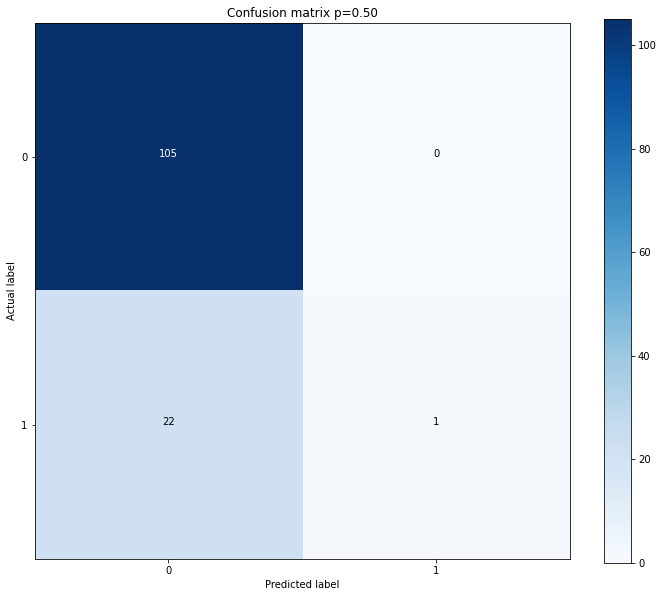

In [ ]:
import pandas as pd
import yaml
import os
import datetime
import random
import dill
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.summary as tf_summary
from imblearn.over_sampling import RandomOverSampler
from math import ceil
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard.plugins.hparams import api as hp
#from src.models.models import *
#from src.visualization.visualize import *
#from src.custom.metrics import F1Score
#from src.data.preprocess import remove_text


def dcnn_resnet(model_config, input_shape, metrics, n_classes=2, output_bias=None, gpus=1):
    '''
    Defines a deep convolutional neural network model for multiclass X-ray classification.
    :param model_config: A dictionary of parameters associated with the model architecture
    :param input_shape: The shape of the model input
    :param metrics: Metrics to track model's performance
    :return: a Keras Model object with the architecture defined in this method
    '''

    # Set hyperparameters
    nodes_dense0 = model_config['NODES_DENSE0']
    lr = model_config['LR']
    dropout = model_config['DROPOUT']
    l2_lambda = model_config['L2_LAMBDA']
    if model_config['OPTIMIZER'] == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif model_config['OPTIMIZER'] == 'sgd':
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = Adam(learning_rate=lr)  # For now, Adam is default option
    init_filters = model_config['INIT_FILTERS']
    filter_exp_base = model_config['FILTER_EXP_BASE']
    conv_blocks = model_config['CONV_BLOCKS']
    kernel_size = eval(model_config['KERNEL_SIZE'])
    max_pool_size = eval(model_config['MAXPOOL_SIZE'])
    strides = eval(model_config['STRIDES'])

    # Set output bias
    if output_bias is not None:
        output_bias = Constant(output_bias)
    print("MODEL CONFIG: ", model_config)

    # Input layer
    X_input = Input(input_shape)
    X = X_input

    # Add convolutional (residual) blocks
    for i in range(conv_blocks):
        X_res = X
        X = Conv2D(init_filters * (filter_exp_base ** i), kernel_size, strides=strides, padding='same',
                         kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda),
                         name='conv' + str(i) + '_0')(X)
        X = BatchNormalization()(X)
        X = LeakyReLU()(X)
        X = Conv2D(init_filters * (filter_exp_base ** i), kernel_size, strides=strides, padding='same',
                         kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda),
                         name='conv' + str(i) + '_1')(X)
        X = concatenate([X, X_res], name='concat' + str(i))
        X = BatchNormalization()(X)
        X = LeakyReLU()(X)
        X = MaxPool2D(max_pool_size, padding='same')(X)

    # Add fully connected layers
    X = Flatten()(X)
    X = Dropout(dropout)(X)
    X = Dense(nodes_dense0, kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda))(X)
    X = LeakyReLU()(X)
    X = Dense(n_classes, bias_initializer=output_bias)(X)
    Y = Activation('softmax', dtype='float32', name='output')(X)

    # Set model loss function, optimizer, metrics.
    model = Model(inputs=X_input, outputs=Y)
    if gpus >= 2:
        model = multi_gpu_model(model, gpus=gpus)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    model.summary()
    return model


def resnet50v2(model_config, input_shape, metrics, n_classes=2, output_bias=None, gpus=1):
    '''
    Defines a model based on a pretrained ResNet50V2 for multiclass X-ray classification.
    :param model_config: A dictionary of parameters associated with the model architecture
    :param input_shape: The shape of the model input
    :param metrics: Metrics to track model's performance
    :return: a Keras Model object with the architecture defined in this method
    '''

    # Set hyperparameters
    nodes_dense0 = model_config['NODES_DENSE0']
    lr = model_config['LR']
    dropout = model_config['DROPOUT']
    l2_lambda = model_config['L2_LAMBDA']
    if model_config['OPTIMIZER'] == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif model_config['OPTIMIZER'] == 'sgd':
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = Adam(learning_rate=lr)  # For now, Adam is default option

    # Set output bias
    if output_bias is not None:
        output_bias = Constant(output_bias)
    print("MODEL CONFIG: ", model_config)

    # Start with pretrained ResNet50V2
    pretrained_resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    X = pretrained_resnet.output

    # Add custom top
    X = GlobalAveragePooling2D()(X)
    X = Dropout(dropout)(X)
    X = Dense(nodes_dense0, kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda))(X)
    X = LeakyReLU()(X)
    X = Dense(n_classes, bias_initializer=output_bias)(X)
    Y = Activation('softmax', dtype='float32', name='output')(X)

    # Set model loss function, optimizer, metrics.
    model = Model(inputs=pretrained_resnet.input, outputs=Y)
    if gpus >= 3:
        model = multi_gpu_model(model, gpus=gpus)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    model.summary()
    return model


def get_class_weights(histogram, class_multiplier=None):
    '''
    Computes weights for each class to be applied in the loss function during training.
    :param histogram: A list depicting the number of each item in different class
    :param class_multiplier: List of values to multiply the calculated class weights by. For further control of class weighting.
    :return: A dictionary containing weights for each class
    '''
    print("histogram")
    print(histogram)
    weights = [None] * len(histogram)
    for i in range(len(histogram)):
        weights[i] = (1.0 / len(histogram)) * sum(histogram) / histogram[i]
    class_weight = {i: weights[i] for i in range(len(histogram))}
    print("inside get class weights")
    print(class_weight)
    print("class multiplier")
    print(class_multiplier)
    if class_multiplier is not None:
        print("class multiplier not none")
        class_weight = [class_weight[i] * class_multiplier[i] for i in range(len(histogram))]
    print("Class weights: ", class_weight)
    return class_weight


def random_minority_oversample(train_set):
    '''
    Oversample the minority class using the specified algorithm
    :param train_set: Training set image file names and labels
    :return: A new training set containing oversampled examples
    '''
    X_train = train_set[[x for x in train_set.columns if x != 'label']].to_numpy()
    if X_train.shape[1] == 1:
        X_train = np.expand_dims(X_train, axis=-1)
    Y_train = train_set['label'].to_numpy()
    sampler = RandomOverSampler(random_state=np.random.randint(0, high=1000))
    X_resampled, Y_resampled = sampler.fit_resample(X_train, Y_train)
    filenames = X_resampled[:, 1]     # Filename is in second column
    label_strs = X_resampled[:, 2]    # Class name is in second column
    print("Train set shape before oversampling: ", X_train.shape, " Train set shape after resampling: ", X_resampled.shape)
    train_set_resampled = pd.DataFrame({'filename': filenames, 'label': Y_resampled, 'label_str': label_strs})
    return train_set_resampled


def train_model(cfg, data, callbacks, verbose=1):
    '''
    Train a and evaluate model on given data.
    :param cfg: Project config (from config.yml)
    :param data: dict of partitioned dataset
    :param callbacks: list of callbacks for Keras model
    :param verbose: Verbosity mode to pass to model.fit_generator()
    :return: Trained model and associated performance metrics on the test set
    '''
    print("before random minority oversample")
    print(data['TRAIN'])
    # If set in config file, oversample the minority class
    if cfg['TRAIN']['IMB_STRATEGY'] == 'random_oversample':
        data['TRAIN'] = random_minority_oversample(data['TRAIN'])

    print("after random minority oversample")
    print(data['TRAIN'])
    # Create ImageDataGenerators
    train_img_gen = ImageDataGenerator(rotation_range=10, preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    val_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)

    print(train_img_gen)
    # Create DataFrameIterators
    print("print train val and test data")
    #pd.set_option("display.max_rows", None, "display.max_columns", None)
    print(data['TRAIN']['filename'])
    print(data['TRAIN']['label_str'])
    print(type(data['TRAIN']))

    print(type(data))
    print(data['VAL'])
    print(data['TEST'])
    img_shape = tuple(cfg['DATA']['IMG_DIM'])
    print("image shape "+str(img_shape))
    y_col = 'label_str'
    class_mode = 'categorical'
    train_generator = train_img_gen.flow_from_dataframe(dataframe=data['TRAIN'], directory='/content/gdrive/My Drive/',
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode)
    val_generator = val_img_gen.flow_from_dataframe(dataframe=data['VAL'], directory='/content/gdrive/My Drive/',
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'], directory='/content/gdrive/My Drive/',
        x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode,
        shuffle=False)

    print("printing")
    print(train_generator)
    print(test_generator)
    print("prining data")
    print(data['TEST'])
    # Save model's ordering of class indices
    print("prining class indices")
    print(train_generator.class_indices)
    print(val_generator.class_indices)
    print(test_generator.class_indices)
    dill.dump(test_generator.class_indices, open(cfg['PATHS']['OUTPUT_CLASS_INDICES'], 'wb'))

    # Apply class imbalance strategy. We have many more X-rays negative for COVID-19 than positive.
    histogram = np.bincount(np.array(train_generator.labels).astype(int))  # Get class distribution
    class_weight = None
    if cfg['TRAIN']['IMB_STRATEGY'] == 'class_weight':
        class_multiplier = cfg['TRAIN']['CLASS_MULTIPLIER']
        class_multiplier = [class_multiplier[cfg['DATA']['CLASSES'].index(c)] for c in test_generator.class_indices]
        print("class multiplier ")
        print(class_multiplier)
        #class_weight = get_class_weights(histogram, class_multiplier)
        class_weight = get_class_weights(histogram, None)

    print("class weight")
    print(class_weight)
    # Define metrics.
    covid_class_idx = test_generator.class_indices['COVID-19']   # Get index of COVID-19 class
    thresholds = 1.0 / len(cfg['DATA']['CLASSES'])      # Binary classification threshold for a class
    metrics = [CategoricalAccuracy(name='accuracy'),
               Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
               Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
               AUC(name='auc'),
               F1Score(name='f1score', thresholds=thresholds, class_id=covid_class_idx)]

    # Define the model.
    print('Training distribution: ', ['Class ' + list(test_generator.class_indices.keys())[i] + ': ' + str(histogram[i]) + '. '
           for i in range(len(histogram))])
    input_shape = cfg['DATA']['IMG_DIM'] + [3]
    num_gpus = cfg['TRAIN']['NUM_GPUS']
    if cfg['TRAIN']['MODEL_DEF'] == 'dcnn_resent':
        model_def = dcnn_resnet
    elif cfg['TRAIN']['MODEL_DEF'] == 'resnet50v2':
        model_def = resnet50v2
    else:
        model_def = resnet101v2
    if cfg['TRAIN']['CLASS_MODE'] == 'binary':
        histogram = np.bincount(data['TRAIN']['label'].astype(int))
        output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
        model = model_def(cfg['NN']['DCNN_BINARY'], input_shape, metrics, 2, output_bias=output_bias, gpus=num_gpus)
    else:
        n_classes = len(cfg['DATA']['CLASSES'])
        histogram = np.bincount(data['TRAIN']['label'].astype(int))
        output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
        model = model_def(cfg['NN']['DCNN_MULTICLASS'], input_shape, metrics, n_classes, output_bias=output_bias,
                          gpus=num_gpus)

    # Train the model.
    steps_per_epoch = ceil(train_generator.n / train_generator.batch_size)
    val_steps = ceil(val_generator.n / val_generator.batch_size)
    '''
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=cfg['TRAIN']['EPOCHS'],
                                  validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks,
                                  verbose=verbose, class_weight=class_weight)
    '''
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=cfg['TRAIN']['EPOCHS'], verbose=verbose, class_weight=class_weight)
    print("model is fitted")
    # Run the model on the test set and print the resulting performance metrics.
    #test_results = model.evaluate_generator(test_generator, verbose=1)
    print("test generator")
    print(test_generator)
    test_results = model.evaluate(test_generator, verbose=1)
    print("evaluate generator")
    print(test_results)
    test_metrics = {}
    test_summary_str = [['**Metric**', '**Value**']]
    for metric, value in zip(model.metrics_names, test_results):
        test_metrics[metric] = value
        print("metric test summary append")
        print(metric, ' = ', value)
        test_summary_str.append([metric, str(value)])
    return model, test_metrics, test_generator



def log_test_results(cfg, model, test_generator, test_metrics, log_dir):
    '''
    Visualize performance of a trained model on the test set. Optionally save the model.
    :param cfg: Project config
    :param model: A trained Keras model
    :param test_generator: A Keras generator for the test set
    :param test_metrics: Dict of test set performance metrics
    :param log_dir: Path to write TensorBoard logs
    '''

    print("inside log_test_results")
    # Visualization of test results
    test_predictions = model.predict_generator(test_generator, verbose=0)
    test_labels = test_generator.labels
    covid_idx = test_generator.class_indices['COVID-19']
    plt = plot_roc("Test set", test_labels, test_predictions, class_id=covid_idx)
    roc_img = plot_to_tensor()
    plt = plot_confusion_matrix(test_labels, test_predictions, class_id=covid_idx)
    cm_img = plot_to_tensor()

    # Log test set results and plots in TensorBoard
    writer = tf_summary.create_file_writer(logdir=log_dir)

    # Create table of test set metrics
    test_summary_str = [['**Metric**','**Value**']]
    thresholds = cfg['TRAIN']['THRESHOLDS']  # Load classification thresholds
    for metric in test_metrics:
        if metric in ['precision', 'recall'] and isinstance(metric, list):
            metric_values = dict(zip(thresholds, test_metrics[metric]))
        else:
            metric_values = test_metrics[metric]
        test_summary_str.append([metric, str(metric_values)])

    # Create table of model and train config values
    hparam_summary_str = [['**Variable**', '**Value**']]
    for key in cfg['TRAIN']:
        hparam_summary_str.append([key, str(cfg['TRAIN'][key])])
    if cfg['TRAIN']['CLASS_MODE'] == 'binary':
        for key in cfg['NN']['DCNN_BINARY']:
            hparam_summary_str.append([key, str(cfg['NN']['DCNN_BINARY'][key])])
    else:
        for key in cfg['NN']['DCNN_BINARY']:
            hparam_summary_str.append([key, str(cfg['NN']['DCNN_BINARY'][key])])

    print("writing to tensorboard logs")
    # Write to TensorBoard logs
    with writer.as_default():
        tf_summary.text(name='Test set metrics', data=tf.convert_to_tensor(test_summary_str), step=0)
        tf_summary.text(name='Run hyperparameters', data=tf.convert_to_tensor(hparam_summary_str), step=0)
        tf_summary.image(name='ROC Curve (Test Set)', data=roc_img, step=0)
        tf_summary.image(name='Confusion Matrix (Test Set)', data=cm_img, step=0)
    return

def train_experiment(cfg=None, experiment='single_train', save_weights=True, write_logs=True):
    '''
    Defines and trains HIFIS-v2 model. Prints and logs relevant metrics.
    :param experiment: The type of training experiment. Choices are {'single_train'}
    :param save_weights: A flag indicating whether to save the model weights
    :param write_logs: A flag indicating whether to write TensorBoard logs
    :return: A dictionary of metrics on the test set
    '''

    # Load project config data
    if cfg is None:
        cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))

    # Set logs directory
    cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    log_dir = cfg['PATHS']['LOGS'] + "training\\" + cur_date if write_logs else None
    if not os.path.exists(cfg['PATHS']['LOGS'] + "training\\"):
        os.makedirs(cfg['PATHS']['LOGS'] + "training\\")

    # Load dataset file paths and labels
    data = {}
    data['TRAIN'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    data['VAL'] = pd.read_csv(cfg['PATHS']['VAL_SET'])
    data['TEST'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Set callbacks.
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=cfg['TRAIN']['PATIENCE'], mode='min', restore_best_weights=True)
    callbacks = [early_stopping]

    # Conduct the desired train experiment
    if experiment == 'hparam_search':
        log_dir = cfg['PATHS']['LOGS'] + "hparam_search\\" + cur_date
        random_hparam_search(cfg, data, callbacks, log_dir)
    else:
        if experiment == 'multi_train':
            base_log_dir = cfg['PATHS']['LOGS'] + "training\\" if write_logs else None
            model, test_metrics, test_generator, cur_date = multi_train(cfg, data, callbacks, base_log_dir)
        else:
            if write_logs:
                tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
                callbacks.append(tensorboard)
            model, test_metrics, test_generator = train_model(cfg, data, callbacks)
            if write_logs:
                print("before calling log_test_results")
                log_test_results(cfg, model, test_generator, test_metrics, log_dir)
        if save_weights:
            print("before saving weights")
            model_path = cfg['PATHS']['MODEL_WEIGHTS'] + 'model' + cur_date + '.h5'
            save_model(model, model_path)  # Save the model's weights
    return

if __name__ == '__main__':
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    print(cfg)
    train_experiment(cfg=cfg, experiment=cfg['TRAIN']['EXPERIMENT_TYPE'], save_weights=True, write_logs=True)

#'results/models/model20200423-231726.h5'

In [ ]:
#!pip3 install PyYAML

UPLOAD config file
create folders - data/processed
               - data/interpretability
              

In [ ]:
#pip install -U PyYAML

     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=4e55f7996c34859cb2731c4a703755be7eaa81320cc289458cacd800158f7a3d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Upload config.yml
create dir - data/processed and data/interpretability
upload data for processed from local
create dir - results/models
create dir - content and upload test.csv from local

rename results/models/"model name"
to results/models/model.h5


It is important that the model's predictions may be explained so as to ensure that the it is making responsible predictions. Model explainability promotes transparency and accountability of decision-making algorithms. Since this model is a neural network, it is difficult to decipher which rules or heuristics it is employing to make its predictions. Since so little is known about presentation of COVID-19, interpretability is all the more important. We used Local Interpretable Model-Agnostic Explanations (i.e. LIME) to explain the predictions of the neural network classifier that we trained. LIME perturbs the features in an example and fits a linear model to approximate the neural network at the local region in the feature space surrounding the example. It then uses the linear model to determine which features were most contributory to the model's prediction for that example. This helps us to understand the model and check based on which features is the model predicting that particular output. So by looking at the output generted by LIME we can analyse what features is our model using to make that prediction and make changes to the model to improve it such that the prediction made by it is explainable and meaningful

In [ ]:
#!pip install lime
import lime

In [ ]:
import pandas as pd
import yaml
import os
import dill
import cv2
import numpy as np
from tqdm import tqdm
from datetime import datetime
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [ ]:
def predict_instance(x, model):
    '''
    Runs model prediction on 1 or more input images.
    :param x: Image(s) to predict
    :param model: A Keras model
    :return: A numpy array comprising a list of class probabilities for each prediction
    '''
    y = model.predict(x)  # Run prediction on the perturbations
    if y.shape[1] == 1:
        probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
    else:
        probs = y
    return probs


def predict_and_explain(x, model, exp, num_features, num_samples):
    '''
    Use the model to predict a single example and apply LIME to generate an explanation.
    :param x: Preprocessed image to predict
    :param model: The trained neural network model
    :param exp: A LimeImageExplainer object
    :param num_features: # of features to use in explanation
    :param num_samples: # of times to perturb the example to be explained
    :return: The LIME explainer for the instance
    '''

    def predict(x):
        '''
        Helper function for LIME explainer. Runs model prediction on perturbations of the example.
        :param x: List of perturbed examples from an example
        :return: A numpy array constituting a list of class probabilities for each predicted perturbation
        '''
        probs = predict_instance(x, model)
        return probs

    # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2.25, max_dist=50, ratio=0.1, sigma=0.15)

    # Generate explanation for the example
    explanation = exp.explain_instance(x, predict, num_features=num_features, num_samples=num_samples, segmentation_fn=segmentation_fn)
    probs = predict_instance(np.expand_dims(x, axis=0), model)
    return explanation, probs


def predict_and_explain_set(raw_img_dir=None, preds_dir=None, save_results=True, give_explanations=True):
    '''
    Preprocess a raw dataset. Then get model predictions and corresponding explanations.
    :param raw_img_dir: Directory in which to look for raw images
    :param preds_dir: Path at which to save results of this prediction
    :param save_results: Flag specifying whether to save the prediction results to disk
    :param give_explanations: Flag specifying whether to provide LIME explanations with predictions spreadsheet
    :return: Dataframe of prediction results, optionally including explanations.
    '''

    # Load project config data
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    cur_date = datetime.now().strftime('%Y%m%d-%H%M%S')

    # Restore the model, LIME explainer, and model class indices from their respective serializations
    model = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)
    explainer = dill.load(open(cfg['PATHS']['LIME_EXPLAINER'], 'rb'))
    class_indices = dill.load(open(cfg['PATHS']['OUTPUT_CLASS_INDICES'], 'rb'))

    # Load LIME and prediction constants from config
    NUM_SAMPLES = cfg['LIME']['NUM_SAMPLES']
    NUM_FEATURES = cfg['LIME']['NUM_FEATURES']
    CLASS_NAMES = cfg['DATA']['CLASSES']

    # Define column names of the DataFrame representing the prediction results
    col_names = ['Image Filename', 'Predicted Class']
    for c in cfg['DATA']['CLASSES']:
        col_names.append('p(' + c + ')')

    # Add columns for client explanation
    if give_explanations:
        col_names.append('Explanation Filename')

    # Set raw image directory based on project config, if not specified
    if raw_img_dir is None:
        raw_img_dir = cfg['PATHS']['BATCH_PRED_IMGS']

    # If no path is specified, create new directory for predictions
    if preds_dir is None:
        preds_dir = cfg['PATHS']['BATCH_PREDS'] + '\\' + cur_date + '\\'
        if save_results and not os.path.exists(cfg['PATHS']['BATCH_PREDS'] + '\\' + cur_date):
            os.mkdir(preds_dir)

    # Create DataFrame for raw image file names
    raw_img_df = pd.DataFrame({'filename': os.listdir(raw_img_dir)})
    raw_img_df = raw_img_df[raw_img_df['filename'].str.contains('jpg|png|jpeg', na=False)]   # Enforce image files

    # Create generator for the image files
    img_gen = ImageDataGenerator(preprocessing_function=remove_text, samplewise_std_normalization=True,
                                 samplewise_center=True)
    img_iter = img_gen.flow_from_dataframe(dataframe=raw_img_df, directory=raw_img_dir, x_col="filename",
                                           target_size=cfg['DATA']['IMG_DIM'], batch_size=1, class_mode=None,
                                           shuffle=False)

    # Predict (and optionally explain) all images in the specified directory
    rows = []
    print('Predicting and explaining examples.')

    for filename in raw_img_df['filename'].tolist():

        # Get preprocessed image and make a prediction.
        try:
            x = img_iter.next()
        except StopIteration:
            break
        y = np.squeeze(predict_instance(x, model))

        # Rearrange prediction probability vector to reflect original ordering of classes in project config
        p = [y[CLASS_NAMES.index(c)] for c in class_indices]
        predicted_class = CLASS_NAMES[np.argmax(p)]
        row = [filename, predicted_class]
        row.extend(list(p))

        # Explain this prediction
        if give_explanations:
            explanation, _ = predict_and_explain(np.squeeze(x, axis=0), model, explainer, NUM_FEATURES, NUM_SAMPLES)
            if cfg['LIME']['COVID_ONLY'] == True:
                label_to_see = class_indices['COVID-19']
            else:
                label_to_see = 'top'

            # Load and resize the corresponding original image (no preprocessing)
            orig_img = cv2.imread(raw_img_dir + filename)
            orig_img = cv2.resize(orig_img, tuple(cfg['DATA']['IMG_DIM']), interpolation=cv2.INTER_NEAREST)

            # Generate visual for explanation
            exp_filename = visualize_explanation(orig_img, explanation, filename, None, p, CLASS_NAMES,
                                                 label_to_see=label_to_see, file_path=preds_dir)
            row.append(exp_filename.split('\\')[-1])
        rows.append(row)

    # Convert results to a Pandas DataFrame and save
    results_df = pd.DataFrame(rows, columns=col_names)
    if save_results:
        results_path = preds_dir + 'predictions.csv'
        results_df.to_csv(results_path, columns=col_names, index_label=False, index=False)
    return results_df


#if __name__ == '__main__':
#    results = predict_and_explain_set(preds_dir=None, save_results=True, give_explanations=True)

We use the trained model to pass to it images from the test dataset which will then be used by LIME to make predictions. The index 'i' in the below code is responsible to select the image on which we are we are trying to expain the model we can change the value assigned to 'i' to check the explanation for different images present in the test dataset.

Found 130 validated image filenames belonging to 2 classes.
test generator



Intercept 2.933736909085865e-16
Prediction_local [1.8687515e-15]
Right: 5.8602426e-25
Intercept 1.0
Prediction_local [1.]
Right: 1.0
Explanation time = 27.487493 seconds


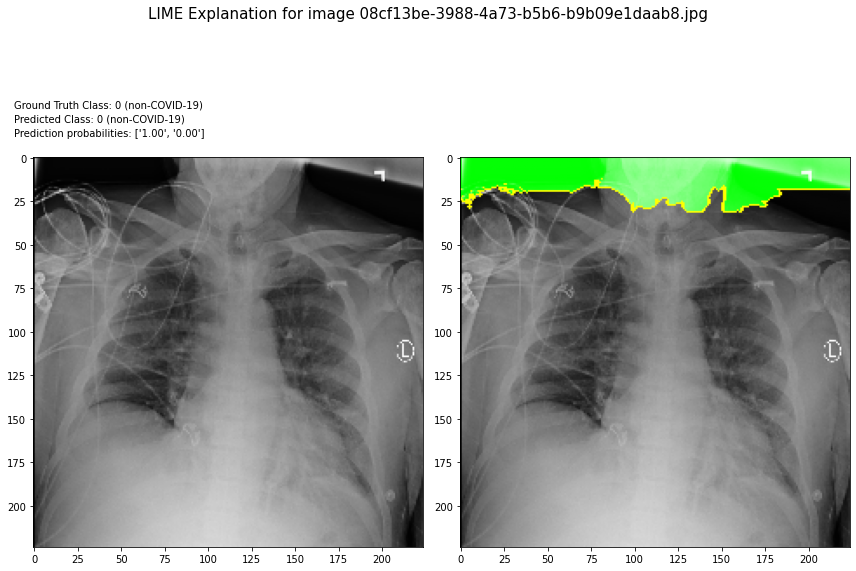

In [ ]:
from lime.lime_image import *
import pandas as pd
import yaml
import os
import datetime
import dill
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from src.visualization.visualize import visualize_explanation
#from src.predict import predict_instance, predict_and_explain
#from src.data.preprocess import remove_text


def setup_lime():
    '''
    Load relevant information and create a LIME Explainer
    :return: dict containing important information and objects for explanation experiments
    '''

    # Load relevant constants from project config file
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    lime_dict = {}
    lime_dict['NUM_SAMPLES'] = cfg['LIME']['NUM_SAMPLES']
    lime_dict['NUM_FEATURES'] = cfg['LIME']['NUM_FEATURES']
    lime_dict['IMG_PATH'] = cfg['PATHS']['IMAGES']
    lime_dict['TEST_IMG_PATH'] = cfg['PATHS']['TEST_IMGS']
    lime_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    lime_dict['PRED_THRESHOLD'] = cfg['PREDICTION']['THRESHOLD']
    lime_dict['CLASSES'] = cfg['DATA']['CLASSES']
    lime_dict['CLASS_MODE'] = cfg['TRAIN']['CLASS_MODE']
    lime_dict['COVID_ONLY'] = cfg['LIME']['COVID_ONLY']
    KERNEL_WIDTH = cfg['LIME']['KERNEL_WIDTH']
    FEATURE_SELECTION = cfg['LIME']['FEATURE_SELECTION']

    # Load train and test sets
    lime_dict['TRAIN_SET'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    #lime_dict['TEST_SET'] = pd.read_csv(cfg['PATHS']['TEST_SET'])
    lime_dict['TEST_SET'] = pd.read_csv("content/test.csv")

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=lime_dict['TEST_SET'], directory=cfg['PATHS']['TEST_IMGS'],
        x_col="filename", y_col='label_str', target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
        class_mode='categorical', shuffle=False)
    print("test generator")
    print(test_generator)
    lime_dict['TEST_GENERATOR'] = test_generator

    # Define the LIME explainer
    lime_dict['EXPLAINER'] = LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION,
                                                verbose=True)
    dill.dump(lime_dict['EXPLAINER'], open(cfg['PATHS']['LIME_EXPLAINER'], 'wb'))    # Serialize the explainer

    # Load trained model's weights
    lime_dict['MODEL'] = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)

    print(lime_dict['MODEL'])
    test_predictions = lime_dict['MODEL'].predict_generator(test_generator, verbose=0)
    return lime_dict


def explain_xray(lime_dict, idx, save_exp=True):
    '''
    Make a prediction and provide a LIME explanation
    :param lime_dict: dict containing important information and objects for explanation experiments
    :param idx: index of image in test set to explain
    :param save_exp: Boolean indicating whether to save the explanation visualization
    '''

    # Get i'th preprocessed image in test set
    lime_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = lime_dict['TEST_GENERATOR'].next()
    x = np.squeeze(x, axis=0)

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread(lime_dict['TEST_IMG_PATH'] + lime_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(lime_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Make a prediction for this image and retrieve a LIME explanation for the prediction
    start_time = datetime.datetime.now()
    explanation, probs = predict_and_explain(x, lime_dict['MODEL'], lime_dict['EXPLAINER'],
                                      lime_dict['NUM_FEATURES'], lime_dict['NUM_SAMPLES'])
    print("Explanation time = " + str((datetime.datetime.now() - start_time).total_seconds()) + " seconds")


    # Get image filename and label
    img_filename = lime_dict['TEST_SET']['filename'][idx]
    label = lime_dict['TEST_SET']['label'][idx]

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_dict['TEST_GENERATOR'].class_indices]

    # Visualize the LIME explanation and optionally save it to disk
    if save_exp:
        file_path = lime_dict['IMG_PATH']
    else:
        file_path = None
    if lime_dict['COVID_ONLY'] == True:
        label_to_see = lime_dict['TEST_GENERATOR'].class_indices['COVID-19']
    else:
        label_to_see = 'top'
    _ = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see, dir_path=file_path)
    return


if __name__ == '__main__':
    lime_dict = setup_lime()
    i = 15                                                      # Select i'th image in test set
    explain_xray(lime_dict, i, save_exp=True)                   # Generate explanation for image

Using SHAP to find model explanations. SHAP is another

In [ ]:
!pip install shap

     |████████████████████████████████| 276kB 37.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394123 sha256=423f96558d5f0c7858a9717a74a09e96ea220dfccd25634937ffc7b83e65df42
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap
from tensorflow.keras.models import load_model

Using TensorFlow backend.


In [ ]:
import os
import pandas as pd

In [ ]:
cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
model = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)

In [ ]:

model.layers[7].input

<tf.Tensor 'batch_normalization_7_6/Identity:0' shape=(None, 224, 224, 19) dtype=float32>

In [ ]:
    lime_dict1 = {}
    lime_dict1['TEST_SET'] = pd.read_csv("content/test.csv")

    # Create ImageDataGenerator for test set
    test_img_gen1 = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen1.flow_from_dataframe(dataframe=lime_dict1['TEST_SET'], directory=cfg['PATHS']['TEST_IMGS'],
        x_col="filename", y_col='label_str', target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
        class_mode='categorical', shuffle=False)
    print("test generator")
    print(test_generator)
    lime_dict1['TEST_GENERATOR'] = test_generator


Found 130 validated image filenames belonging to 2 classes.
test generator
